In [ ]:
#!pip install numba

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numba
import numba.cuda as cuda

import numpy as np
import matplotlib.pyplot as plt

import cv2

import time

Mounted at /content/drive


sizes : 
(32, 32)
(50, 33)


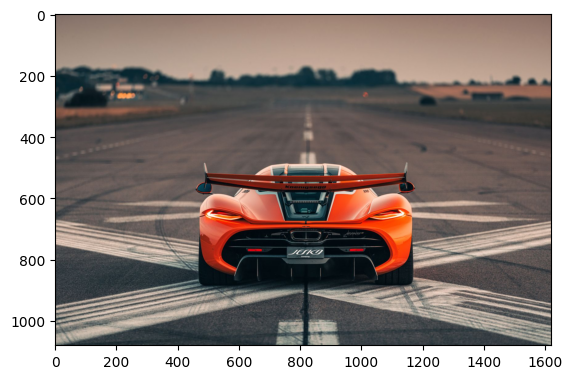

(1080, 1619, 3)
(32, 32)
(50, 33)


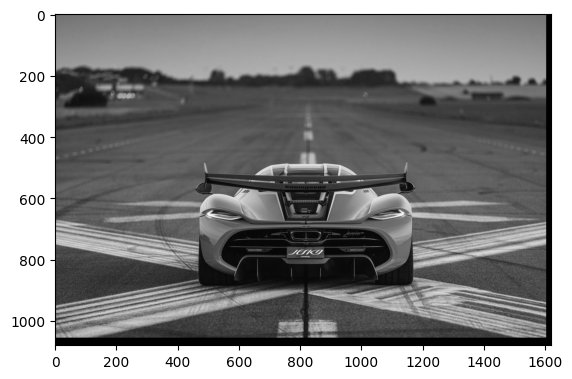

Time to run is: 


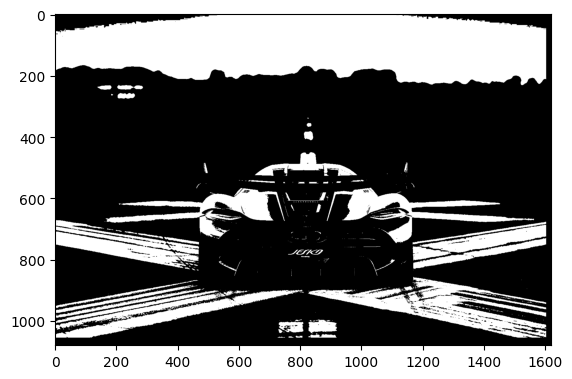

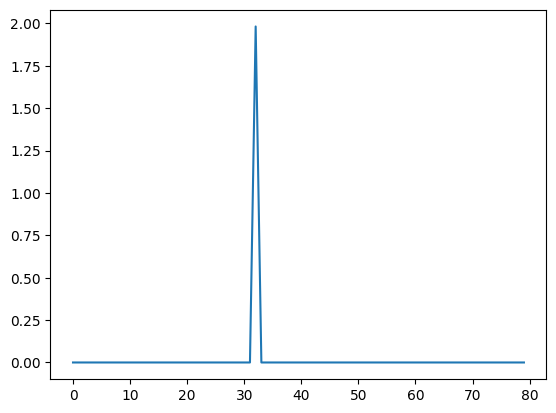

In [2]:

hostData = plt.imread("/content/drive/MyDrive/jesko.jpg")

imageHeight = hostData.shape[0]
imageWidth = hostData.shape[1]
blockSize = (32,32)
gridX = imageWidth / blockSize[0]
gridY = imageHeight / blockSize[1]
gridSize = (int(gridX),int(gridY))
maxBlockSize = 80

print("sizes : ")
print(blockSize)
print(gridSize)

#hostData = np.random.randint(0, 255, (imageHeight, imageWidth, 3), dtype=np.uint8)
plt.imshow(hostData)
plt.show()

@cuda.jit
def binarization(value,threshold):
  if (value > threshold):
    return 1
  else: return 0

#kernelName[numBlock, blockSize](args)
@cuda.jit
def map_binary(src, dst):
  #tid =
  #dst[tid] = f(src[tid])
  threshold = 0.5 * 255

  #tid = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

  srcSizeW = src.shape[1]
  srcSizeH = src.shape[0]
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  x = tidx #% srcSize
  y = tidy #// srcSize

  if x < srcSizeW and y < srcSizeH:
    bin = binarization(src[y,x,0], threshold)
    dst[y,x,0] = dst[y,x,1] = dst[y,x,2] = bin*255


 # if (src[tid][0] > threshold):
 #   binary = 1
 # else: binary = 0


 # dst[tid][0] = dst[tid][1] = dst[tid][2] = binary


@cuda.jit
def grayscale(src, dst):
  srcSizeW = src.shape[1]
  srcSizeH = src.shape[0]
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  x = tidx #% srcSize
  y = tidy #// srcSize

  if x < srcSizeW and y < srcSizeH:
    gray = np.uint8 ((src[y,x,0]+src[y,x,1]+ src[y,x,2]) / 3)
    dst[y,x, 0] = dst[y,x, 1] = dst[y,x, 2] = gray

time_per_block_size = np.zeros(maxBlockSize)


for i in range(1,2):
  if i<=32:
    blockSize = (i*32,i*32)


  start_time = time.time()

  print(hostData.shape)
  devData = cuda.to_device(hostData)
  #devData = cuda.device_array
  devTemp = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  devOutput = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)

  pixelCount = imageWidth * imageHeight
  gridSize = (int(imageWidth / blockSize[0]), int(imageHeight / blockSize[1]))

  print(blockSize)
  print(gridSize)

  grayscale[gridSize, blockSize](devData, devTemp)

  plt.imshow(devTemp)
  plt.show()

  map_binary[gridSize, blockSize](devTemp, devOutput)

  hostOutput = devOutput.copy_to_host()

  end_time = time.time()
  run_time = end_time-start_time
  np.append(time_per_block_size, run_time)
  time_per_block_size[blockSize[0]] = run_time
  #print(run_time)

print("Time to run is: ")
#print(time_per_block_size)
time_per_block_size[0] = 0

plt.imshow(hostOutput)
plt.show()
plt.plot(time_per_block_size)
plt.show()